In [1]:
!pip install stable-baselines3
!pip install gymnasium
!pip install yfinance
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scipy
!pip install statsmodels
!pip install scikit-learn

COMPREHENSIVE TRADING STRATEGY BENCHMARK

1. Downloading and preparing data...
Downloaded 1394 data points for RELIANCE.NS
Train: 975 | Validation: 209 | Test: 210

2. Training DQN model...
Using cuda device
Training DQN model...
Logging to benchmark_models/DQN_5
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3443     |
|    time_elapsed     | 1        |
|    total_timesteps  | 3816     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3735     |
|    time_elapsed     | 2        |
|    total_timesteps  | 7632     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.751    |
|

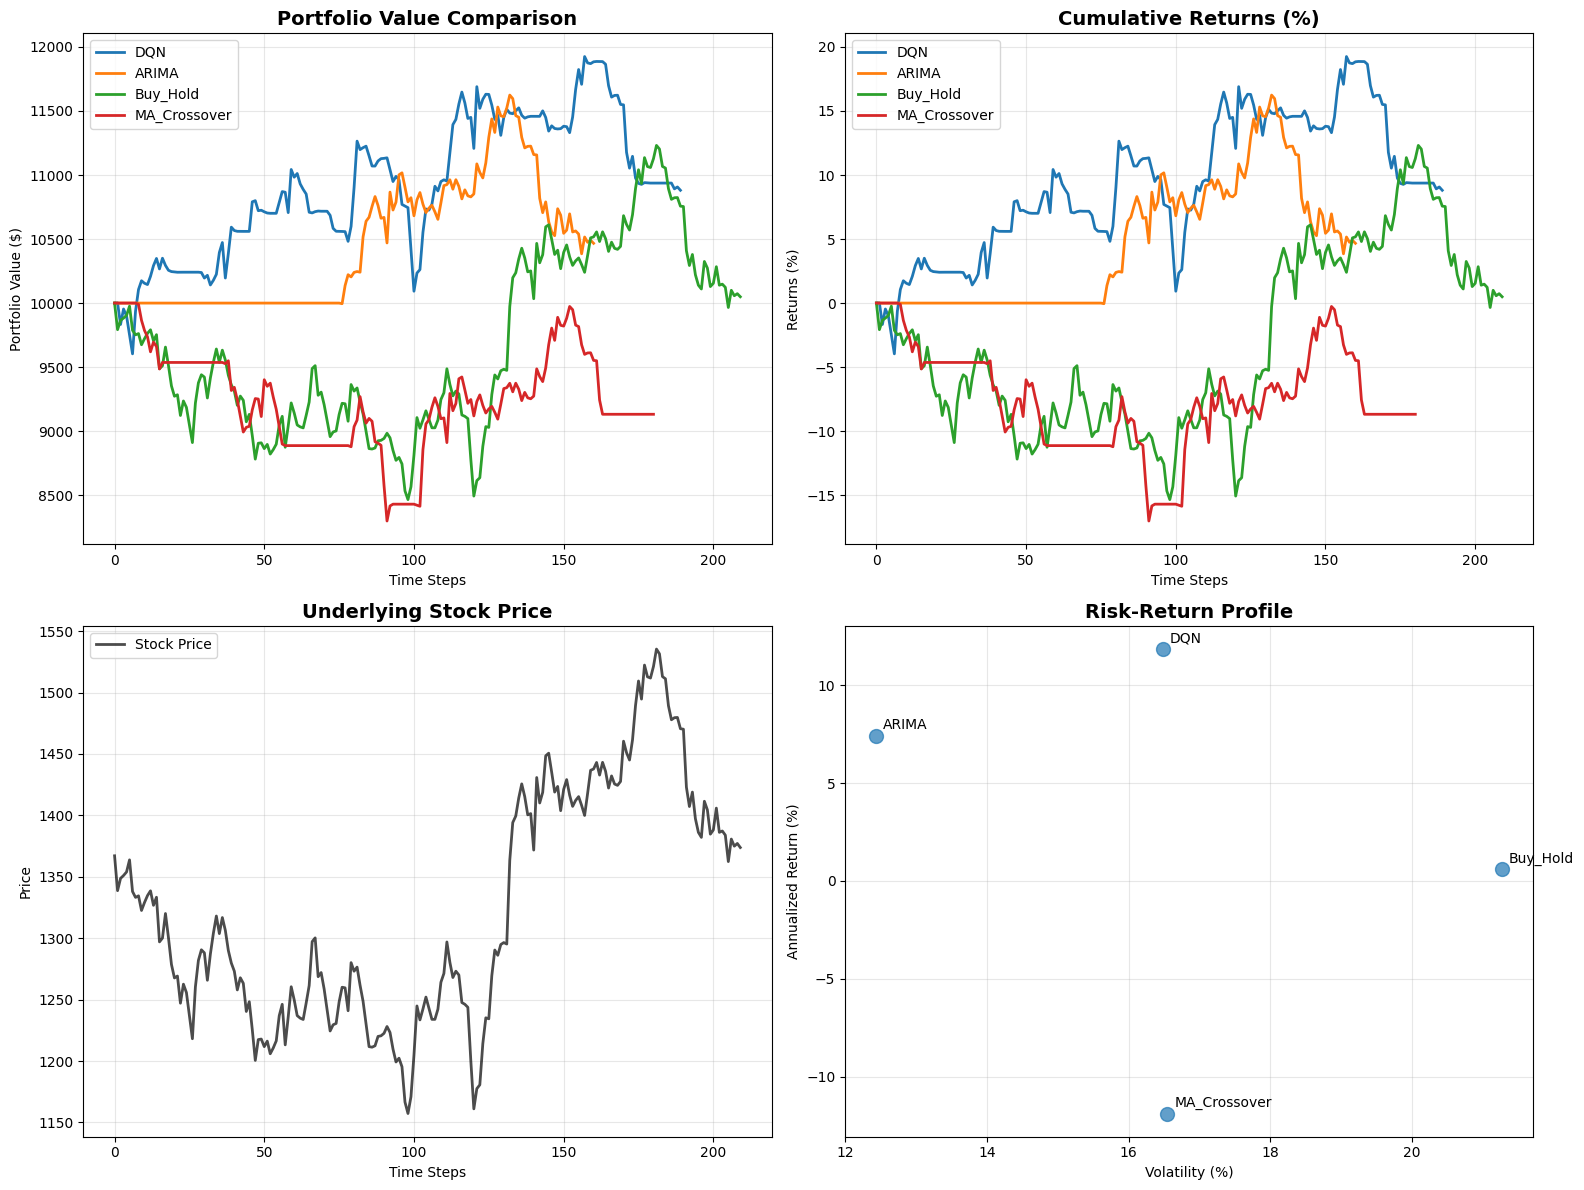


DETAILED STRATEGY ANALYSIS

DQN Strategy:
  Final Portfolio Value: $0.00
  Total Trades: 154
  Action Distribution:
    Buy40%: 5 (2.6%)
    Buy60%: 29 (15.3%)
    Buy80%: 70 (37.0%)
    Sell20%: 4 (2.1%)
    Sell40%: 21 (11.1%)
    Sell60%: 25 (13.2%)
    Sell80%: 32 (16.9%)
    Sell100%: 3 (1.6%)

ARIMA Strategy:
  Final Portfolio Value: $10,466.74
  Total Trades: 4
  Avg Predicted Return: 0.0008
  Prediction Std: 0.0050

Buy_Hold Strategy:
  Final Portfolio Value: $10,049.27
  Total Trades: 1

MA_Crossover Strategy:
  Final Portfolio Value: $9,131.69
  Total Trades: 8

BEST PERFORMING STRATEGIES
Best Total Return: DQN (8.81%)
Best Sharpe Ratio: DQN (0.765)
Best Risk-Adjusted: DQN (Calmar: 1.139)

BENCHMARK COMPLETED SUCCESSFULLY!

Results saved to: benchmark_results_20250815_190629.csv


In [6]:
"""
Comprehensive trading benchmark comparing DQN, ARIMA, and baseline strategies.
Includes statistical tests and detailed performance analysis.
"""

import os
import warnings
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict, Any
import time

import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

# ML and DQN imports
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed

# ARIMA imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


# ========================
# 1) Enhanced Trading Environment
# ========================
class StockTradingEnv(gym.Env):
    """Enhanced trading environment with detailed logging."""

    metadata = {"render_modes": ["human"]}

    def __init__(self, df: pd.DataFrame, initial_balance: float = 10_000.0, window_size: int = 20):
        super().__init__()
        req = ["open", "high", "low", "close", "volume"]
        if not all(c in df.columns for c in req):
            missing = [c for c in req if c not in df.columns]
            raise ValueError(f"Missing required columns: {missing}")

        self.price_df = df[req].copy().astype(float)
        self.feature_df = self._create_features(df).dropna().reset_index(drop=True)

        min_len = min(len(self.price_df), len(self.feature_df))
        self.price_df = self.price_df.iloc[-min_len:].reset_index(drop=True)
        self.feature_df = self.feature_df.iloc[-min_len:].reset_index(drop=True)

        self.initial_balance = float(initial_balance)
        self.window_size = int(window_size)
        self.transaction_cost = 0.001

        self.action_space = gym.spaces.Discrete(11)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window_size, self.feature_df.shape[1]),
            dtype=np.float32,
        )

        self.reset()

    def _create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create comprehensive technical indicators."""
        close = df["close"].astype(float)
        high = df["high"].astype(float)
        low = df["low"].astype(float)
        volume = df["volume"].astype(float)

        features = pd.DataFrame(index=df.index)

        # Basic features
        features["returns"] = close.pct_change()
        features["log_returns"] = np.log(close / close.shift(1))
        features["high_low_ratio"] = (high - low) / (close + 1e-8)
        features["close_open_ratio"] = (close - df["open"]) / (df["open"] + 1e-8)

        # Moving averages ratios
        for period in [5, 10, 20, 50]:
            ma = close.rolling(period).mean()
            features[f"ma_{period}_ratio"] = close / (ma + 1e-8) - 1

        # RSI
        delta = close.diff()
        gain = delta.clip(lower=0).rolling(14).mean()
        loss = (-delta.clip(upper=0)).rolling(14).mean()
        rs = gain / (loss + 1e-8)
        rsi = 100 - (100 / (1 + rs))
        features["rsi_normalized"] = (rsi - 50) / 50

        # MACD
        ema12 = close.ewm(span=12).mean()
        ema26 = close.ewm(span=26).mean()
        macd = ema12 - ema26
        signal = macd.ewm(span=9).mean()
        features["macd_normalized"] = macd / (close + 1e-8)
        features["macd_signal_normalized"] = signal / (close + 1e-8)
        features["macd_histogram"] = (macd - signal) / (close + 1e-8)

        # Bollinger Bands
        bb_middle = close.rolling(20).mean()
        bb_std = close.rolling(20).std()
        features["bb_position"] = (close - bb_middle) / (bb_std + 1e-8)
        features["bb_width"] = (2 * bb_std) / (bb_middle + 1e-8)

        # Volume indicators
        vol_ma = volume.rolling(20).mean()
        features["volume_ratio"] = volume / (vol_ma + 1e-8) - 1
        features["price_volume"] = features["returns"] * features["volume_ratio"]

        # Volatility
        features["volatility"] = close.rolling(20).std() / (close.rolling(20).mean() + 1e-8)

        # Momentum indicators
        for period in [3, 5, 10, 20]:
            features[f"momentum_{period}"] = close.pct_change(period)

        # Price position in recent range
        for period in [10, 20, 50]:
            period_high = high.rolling(period).max()
            period_low = low.rolling(period).min()
            features[f"price_position_{period}"] = (close - period_low) / (period_high - period_low + 1e-8)

        return features.fillna(0)

    def _get_observation(self) -> np.ndarray:
        start = max(0, self.current_step - self.window_size)
        obs = self.feature_df.iloc[start:self.current_step].values

        if obs.shape[0] < self.window_size:
            pad_size = self.window_size - obs.shape[0]
            pad = np.zeros((pad_size, obs.shape[1]), dtype=np.float32)
            obs = np.vstack([pad, obs])

        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)
        return obs.astype(np.float32)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.balance = float(self.initial_balance)
        self.shares_held = 0.0
        self.current_step = self.window_size
        self.portfolio_history = []
        self.trade_history = []
        self.action_history = []
        self.max_portfolio_value = float(self.initial_balance)

        return self._get_observation(), {}

    def _get_current_price(self) -> float:
        return float(self.price_df.iloc[self.current_step]["close"])

    def _calculate_portfolio_value(self) -> float:
        current_price = self._get_current_price()
        return self.balance + self.shares_held * current_price

    def step(self, action: int):
        if self.current_step >= len(self.price_df) - 1:
            return self._get_observation(), 0, True, False, {}

        current_price = self._get_current_price()
        prev_portfolio_value = self._calculate_portfolio_value()

        # Execute action and record
        self._execute_action(action, current_price)
        self.action_history.append(action)

        self.current_step += 1
        new_portfolio_value = self._calculate_portfolio_value()
        self.portfolio_history.append(new_portfolio_value)
        self.max_portfolio_value = max(self.max_portfolio_value, new_portfolio_value)

        # Calculate reward
        if prev_portfolio_value > 0:
            step_return = (new_portfolio_value - prev_portfolio_value) / prev_portfolio_value
        else:
            step_return = 0

        drawdown = (self.max_portfolio_value - new_portfolio_value) / self.max_portfolio_value if self.max_portfolio_value > 0 else 0
        reward = step_return * 100 - drawdown * 50

        terminated = self.current_step >= len(self.price_df) - 1
        if terminated:
            total_return = (new_portfolio_value - self.initial_balance) / self.initial_balance
            terminal_reward = total_return * 200
            reward += terminal_reward

        info = {
            "portfolio_value": new_portfolio_value,
            "balance": self.balance,
            "shares": self.shares_held,
            "price": current_price,
            "total_trades": len(self.trade_history),
            "step_return": step_return,
        }

        return self._get_observation(), reward, terminated, False, info

    def _execute_action(self, action: int, current_price: float):
        action_fractions = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

        if action == 0:
            return

        elif 1 <= action <= 5:  # Buy
            fraction = action_fractions[action]
            max_investment = self.balance * fraction
            max_shares = max_investment / (current_price * (1 + self.transaction_cost))

            if max_shares >= 0.01:
                cost = max_shares * current_price * (1 + self.transaction_cost)
                if cost <= self.balance:
                    self.balance -= cost
                    self.shares_held += max_shares
                    self.trade_history.append({
                        "step": self.current_step,
                        "action": "buy",
                        "shares": max_shares,
                        "price": current_price,
                        "cost": cost
                    })

        elif 6 <= action <= 10:  # Sell
            fraction = action_fractions[action - 5]
            shares_to_sell = self.shares_held * fraction

            if shares_to_sell >= 0.01:
                proceeds = shares_to_sell * current_price * (1 - self.transaction_cost)
                self.balance += proceeds
                self.shares_held -= shares_to_sell
                self.trade_history.append({
                    "step": self.current_step,
                    "action": "sell",
                    "shares": shares_to_sell,
                    "price": current_price,
                    "proceeds": proceeds
                })


# ========================
# 2) ARIMA Trading Strategy
# ========================
class ARIMATrader:
    """ARIMA-based trading strategy with automatic parameter selection."""

    def __init__(self, initial_balance: float = 10_000.0, transaction_cost: float = 0.001):
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.balance = initial_balance
        self.shares_held = 0.0
        self.trade_history = []
        self.portfolio_history = []
        self.predictions = []
        self.model_params = None

    def _check_stationarity(self, series: pd.Series) -> Tuple[bool, float]:
        """Check if series is stationary using Augmented Dickey-Fuller test."""
        result = adfuller(series.dropna())
        return result[1] < 0.05, result[1]  # p-value < 0.05 means stationary

    def _find_best_arima_params(self, series: pd.Series, max_p: int = 5, max_d: int = 2, max_q: int = 5) -> Tuple[int, int, int]:
        """Find best ARIMA parameters using AIC."""
        best_aic = float('inf')
        best_params = (1, 1, 1)

        # Make series stationary if needed
        diff_series = series.copy()
        d = 0

        for d_test in range(max_d + 1):
            is_stationary, p_value = self._check_stationarity(diff_series)
            if is_stationary:
                d = d_test
                break
            diff_series = diff_series.diff().dropna()

        # Grid search for best p and q
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_params = (p, d, q)
                except:
                    continue

        return best_params

    def fit(self, train_data: pd.DataFrame, lookback_window: int = 50):
        """Fit ARIMA model on training data."""
        self.lookback_window = lookback_window
        prices = train_data['close'].astype(float)

        # Use log returns for better stationarity
        log_returns = np.log(prices / prices.shift(1)).dropna()

        print("Finding optimal ARIMA parameters...")
        self.model_params = self._find_best_arima_params(log_returns)
        print(f"Selected ARIMA{self.model_params} parameters")

        return self

    def _predict_next_return(self, recent_returns: pd.Series) -> float:
        """Predict next period return using ARIMA."""
        try:
            model = ARIMA(recent_returns, order=self.model_params)
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=1)
            return float(forecast.iloc[0]) if hasattr(forecast, 'iloc') else float(forecast)
        except:
            return 0.0  # Return 0 if model fails

    def trade(self, test_data: pd.DataFrame, confidence_threshold: float = 0.01) -> Dict[str, Any]:
        """Execute ARIMA-based trading strategy."""
        prices = test_data['close'].astype(float).reset_index(drop=True)

        self.balance = self.initial_balance
        self.shares_held = 0.0
        self.trade_history = []
        self.portfolio_history = [self.initial_balance]
        self.predictions = []

        # Calculate log returns for the entire series
        log_returns = np.log(prices / prices.shift(1)).fillna(0)

        for i in range(self.lookback_window, len(prices) - 1):
            current_price = prices.iloc[i]

            # Get recent returns for prediction
            recent_returns = log_returns.iloc[max(0, i - self.lookback_window):i]

            # Predict next return
            predicted_return = self._predict_next_return(recent_returns)
            self.predictions.append(predicted_return)

            # Trading logic based on prediction
            current_portfolio_value = self.balance + self.shares_held * current_price

            if predicted_return > confidence_threshold:  # Bullish signal
                # Buy with 50% of available cash
                investment = self.balance * 0.5
                if investment > 0:
                    shares_to_buy = investment / (current_price * (1 + self.transaction_cost))
                    if shares_to_buy >= 0.01:  # Minimum trade size
                        cost = shares_to_buy * current_price * (1 + self.transaction_cost)
                        self.balance -= cost
                        self.shares_held += shares_to_buy

                        self.trade_history.append({
                            "step": i,
                            "action": "buy",
                            "shares": shares_to_buy,
                            "price": current_price,
                            "predicted_return": predicted_return,
                            "cost": cost
                        })

            elif predicted_return < -confidence_threshold:  # Bearish signal
                # Sell 50% of holdings
                shares_to_sell = self.shares_held * 0.5
                if shares_to_sell >= 0.01:
                    proceeds = shares_to_sell * current_price * (1 - self.transaction_cost)
                    self.balance += proceeds
                    self.shares_held -= shares_to_sell

                    self.trade_history.append({
                        "step": i,
                        "action": "sell",
                        "shares": shares_to_sell,
                        "price": current_price,
                        "predicted_return": predicted_return,
                        "proceeds": proceeds
                    })

            # Record portfolio value
            new_portfolio_value = self.balance + self.shares_held * current_price
            self.portfolio_history.append(new_portfolio_value)

        # Final portfolio value
        final_price = prices.iloc[-1]
        final_portfolio_value = self.balance + self.shares_held * final_price
        self.portfolio_history.append(final_portfolio_value)

        return {
            "final_portfolio_value": final_portfolio_value,
            "total_return": (final_portfolio_value - self.initial_balance) / self.initial_balance * 100,
            "total_trades": len(self.trade_history),
            "predictions": self.predictions,
            "portfolio_history": self.portfolio_history
        }


# ========================
# 3) Baseline Strategies
# ========================
class BaselineStrategies:
    """Collection of baseline trading strategies."""

    @staticmethod
    def buy_and_hold(test_data: pd.DataFrame, initial_balance: float = 10_000.0) -> Dict[str, Any]:
        """Simple buy and hold strategy."""
        prices = test_data['close'].astype(float)
        start_price = prices.iloc[0]
        shares = initial_balance / start_price

        portfolio_values = shares * prices
        final_value = portfolio_values.iloc[-1]

        return {
            "final_portfolio_value": final_value,
            "total_return": (final_value - initial_balance) / initial_balance * 100,
            "total_trades": 1,
            "portfolio_history": portfolio_values.tolist()
        }

    @staticmethod
    def moving_average_crossover(test_data: pd.DataFrame, initial_balance: float = 10_000.0,
                                short_window: int = 10, long_window: int = 30) -> Dict[str, Any]:
        """Moving average crossover strategy."""
        prices = test_data['close'].astype(float)
        short_ma = prices.rolling(short_window).mean()
        long_ma = prices.rolling(long_window).mean()

        balance = initial_balance
        shares_held = 0.0
        portfolio_history = [initial_balance]
        trade_history = []
        transaction_cost = 0.001

        for i in range(long_window, len(prices)):
            current_price = prices.iloc[i]

            # Buy signal: short MA crosses above long MA
            if short_ma.iloc[i] > long_ma.iloc[i] and short_ma.iloc[i-1] <= long_ma.iloc[i-1]:
                if balance > 0:
                    shares_to_buy = balance / (current_price * (1 + transaction_cost))
                    cost = shares_to_buy * current_price * (1 + transaction_cost)
                    balance -= cost
                    shares_held += shares_to_buy
                    trade_history.append({"action": "buy", "price": current_price, "shares": shares_to_buy})

            # Sell signal: short MA crosses below long MA
            elif short_ma.iloc[i] < long_ma.iloc[i] and short_ma.iloc[i-1] >= long_ma.iloc[i-1]:
                if shares_held > 0:
                    proceeds = shares_held * current_price * (1 - transaction_cost)
                    balance += proceeds
                    trade_history.append({"action": "sell", "price": current_price, "shares": shares_held})
                    shares_held = 0.0

            portfolio_value = balance + shares_held * current_price
            portfolio_history.append(portfolio_value)

        final_value = portfolio_history[-1]
        return {
            "final_portfolio_value": final_value,
            "total_return": (final_value - initial_balance) / initial_balance * 100,
            "total_trades": len(trade_history),
            "portfolio_history": portfolio_history
        }


# ========================
# 4) Comprehensive Benchmarking System
# ========================
class TradingBenchmark:
    """Comprehensive benchmarking system for trading strategies."""

    def __init__(self, initial_balance: float = 10_000.0):
        self.initial_balance = initial_balance
        self.results = {}

    def calculate_metrics(self, portfolio_values: List[float], strategy_name: str) -> Dict[str, float]:
        """Calculate comprehensive performance metrics."""
        portfolio_values = np.array(portfolio_values)
        returns = np.diff(portfolio_values) / portfolio_values[:-1]
        returns = returns[np.isfinite(returns)]  # Remove inf/nan

        if len(returns) == 0:
            return {"error": "No valid returns"}

        metrics = {}

        # Basic metrics
        metrics["total_return"] = (portfolio_values[-1] - self.initial_balance) / self.initial_balance * 100
        metrics["annualized_return"] = ((portfolio_values[-1] / self.initial_balance) ** (252 / len(portfolio_values)) - 1) * 100

        # Risk metrics
        metrics["volatility"] = np.std(returns) * np.sqrt(252) * 100
        metrics["sharpe_ratio"] = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0

        # Drawdown metrics
        peak = np.maximum.accumulate(portfolio_values)
        drawdowns = (peak - portfolio_values) / peak * 100
        metrics["max_drawdown"] = np.max(drawdowns)
        metrics["avg_drawdown"] = np.mean(drawdowns[drawdowns > 0]) if np.any(drawdowns > 0) else 0

        # Win rate and other metrics
        winning_days = np.sum(returns > 0)
        total_days = len(returns)
        metrics["win_rate"] = winning_days / total_days * 100 if total_days > 0 else 0

        # Calmar ratio (return/max_drawdown)
        metrics["calmar_ratio"] = metrics["annualized_return"] / metrics["max_drawdown"] if metrics["max_drawdown"] > 0 else 0

        # Sortino ratio (downside deviation)
        downside_returns = returns[returns < 0]
        downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 1e-8
        metrics["sortino_ratio"] = np.mean(returns) / downside_std * np.sqrt(252)

        return metrics

    def run_dqn_strategy(self, model: DQN, test_data: pd.DataFrame) -> Dict[str, Any]:
        """Run DQN strategy evaluation."""
        print("Running DQN strategy...")
        env = StockTradingEnv(test_data, initial_balance=self.initial_balance)
        obs, _ = env.reset(seed=42)

        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(int(action))

            if terminated or truncated:
                break

        return {
            "portfolio_history": [self.initial_balance] + env.portfolio_history,
            "trade_history": env.trade_history,
            "action_history": env.action_history,
            "total_trades": len(env.trade_history)
        }

    def run_arima_strategy(self, train_data: pd.DataFrame, test_data: pd.DataFrame) -> Dict[str, Any]:
        """Run ARIMA strategy evaluation."""
        print("Running ARIMA strategy...")
        arima_trader = ARIMATrader(initial_balance=self.initial_balance)
        arima_trader.fit(train_data)
        return arima_trader.trade(test_data)

    def run_all_strategies(self, dqn_model: DQN, train_data: pd.DataFrame, test_data: pd.DataFrame) -> Dict[str, Dict]:
        """Run all strategies and collect results."""
        strategies = {}

        # DQN Strategy
        try:
            dqn_results = self.run_dqn_strategy(dqn_model, test_data)
            strategies["DQN"] = dqn_results
        except Exception as e:
            print(f"DQN strategy failed: {e}")
            strategies["DQN"] = {"error": str(e)}

        # ARIMA Strategy
        try:
            arima_results = self.run_arima_strategy(train_data, test_data)
            strategies["ARIMA"] = arima_results
        except Exception as e:
            print(f"ARIMA strategy failed: {e}")
            strategies["ARIMA"] = {"error": str(e)}

        # Baseline Strategies
        try:
            strategies["Buy_Hold"] = BaselineStrategies.buy_and_hold(test_data, self.initial_balance)
        except Exception as e:
            print(f"Buy & Hold strategy failed: {e}")
            strategies["Buy_Hold"] = {"error": str(e)}

        try:
            strategies["MA_Crossover"] = BaselineStrategies.moving_average_crossover(test_data, self.initial_balance)
        except Exception as e:
            print(f"MA Crossover strategy failed: {e}")
            strategies["MA_Crossover"] = {"error": str(e)}

        return strategies

    def compare_strategies(self, strategies: Dict[str, Dict]) -> pd.DataFrame:
        """Create comprehensive comparison table."""
        comparison_data = []

        for name, results in strategies.items():
            if "error" in results:
                continue

            portfolio_history = results.get("portfolio_history", [])
            if not portfolio_history:
                continue

            metrics = self.calculate_metrics(portfolio_history, name)

            row = {
                "Strategy": name,
                "Final_Value": results.get("final_portfolio_value", portfolio_history[-1]),
                "Total_Return_%": metrics.get("total_return", 0),
                "Annualized_Return_%": metrics.get("annualized_return", 0),
                "Volatility_%": metrics.get("volatility", 0),
                "Sharpe_Ratio": metrics.get("sharpe_ratio", 0),
                "Max_Drawdown_%": metrics.get("max_drawdown", 0),
                "Calmar_Ratio": metrics.get("calmar_ratio", 0),
                "Sortino_Ratio": metrics.get("sortino_ratio", 0),
                "Win_Rate_%": metrics.get("win_rate", 0),
                "Total_Trades": results.get("total_trades", 0)
            }
            comparison_data.append(row)

        return pd.DataFrame(comparison_data)

    def plot_comparison(self, strategies: Dict[str, Dict], test_data: pd.DataFrame):
        """Create comprehensive comparison plots."""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Portfolio Value Comparison
        ax1 = axes[0, 0]
        for name, results in strategies.items():
            if "error" in results or "portfolio_history" not in results:
                continue
            portfolio_history = results["portfolio_history"]
            ax1.plot(portfolio_history, label=f"{name}", linewidth=2)

        ax1.set_title("Portfolio Value Comparison", fontsize=14, fontweight='bold')
        ax1.set_xlabel("Time Steps")
        ax1.set_ylabel("Portfolio Value ($)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Cumulative Returns
        ax2 = axes[0, 1]
        for name, results in strategies.items():
            if "error" in results or "portfolio_history" not in results:
                continue
            portfolio_history = np.array(results["portfolio_history"])
            cum_returns = (portfolio_history / self.initial_balance - 1) * 100
            ax2.plot(cum_returns, label=f"{name}", linewidth=2)

        ax2.set_title("Cumulative Returns (%)", fontsize=14, fontweight='bold')
        ax2.set_xlabel("Time Steps")
        ax2.set_ylabel("Returns (%)")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Stock Price
        ax3 = axes[1, 0]
        prices = test_data['close'].values
        ax3.plot(prices, label='Stock Price', color='black', alpha=0.7, linewidth=2)
        ax3.set_title("Underlying Stock Price", fontsize=14, fontweight='bold')
        ax3.set_xlabel("Time Steps")
        ax3.set_ylabel("Price")
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Risk-Return Scatter
        ax4 = axes[1, 1]
        returns = []
        volatilities = []
        strategy_names = []

        for name, results in strategies.items():
            if "error" in results or "portfolio_history" not in results:
                continue
            portfolio_history = results["portfolio_history"]
            metrics = self.calculate_metrics(portfolio_history, name)

            returns.append(metrics.get("annualized_return", 0))
            volatilities.append(metrics.get("volatility", 0))
            strategy_names.append(name)

        scatter = ax4.scatter(volatilities, returns, s=100, alpha=0.7)
        for i, name in enumerate(strategy_names):
            ax4.annotate(name, (volatilities[i], returns[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

        ax4.set_title("Risk-Return Profile", fontsize=14, fontweight='bold')
        ax4.set_xlabel("Volatility (%)")
        ax4.set_ylabel("Annualized Return (%)")
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def statistical_tests(self, strategies: Dict[str, Dict]) -> Dict[str, Dict]:
        """Perform statistical tests on strategy returns."""
        results = {}

        # Get daily returns for each strategy
        strategy_returns = {}
        for name, data in strategies.items():
            if "error" in data or "portfolio_history" not in data:
                continue
            portfolio_values = np.array(data["portfolio_history"])
            daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
            daily_returns = daily_returns[np.isfinite(daily_returns)]
            strategy_returns[name] = daily_returns

        # Pairwise statistical tests
        strategy_names = list(strategy_returns.keys())
        for i, strategy1 in enumerate(strategy_names):
            for j, strategy2 in enumerate(strategy_names[i+1:], i+1):
                returns1 = strategy_returns[strategy1]
                returns2 = strategy_returns[strategy2]

                # T-test for mean difference
                t_stat, t_pvalue = stats.ttest_ind(returns1, returns2)

                # Mann-Whitney U test (non-parametric)
                u_stat, u_pvalue = stats.mannwhitneyu(returns1, returns2, alternative='two-sided')

                # Kolmogorov-Smirnov test
                ks_stat, ks_pvalue = stats.ks_2samp(returns1, returns2)

                test_key = f"{strategy1}_vs_{strategy2}"
                results[test_key] = {
                    "t_test_pvalue": t_pvalue,
                    "mann_whitney_pvalue": u_pvalue,
                    "ks_test_pvalue": ks_pvalue,
                    "significantly_different": min(t_pvalue, u_pvalue, ks_pvalue) < 0.05
                }

        return results


# ========================
# 5) Data Loading and DQN Training Functions
# ========================
@dataclass
class DataConfig:
    ticker: str = "^NSEI"
    start_date: str = "2020-01-01"
    end_date: Optional[str] = None
    try_fallbacks: bool = True
    fallbacks: Tuple[str, ...] = ("NIFTYBEES.NS", "^NSEI", "^NSEBANK", "TCS.NS", "INFY.NS")

def download_stock_data(cfg: DataConfig) -> pd.DataFrame:
    """Download stock data with fallback options."""
    end = cfg.end_date or datetime.now().strftime("%Y-%m-%d")

    def _attempt(tick: str) -> Optional[pd.DataFrame]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df = yf.download(tick, start=cfg.start_date, end=end, progress=False)

            if df is None or len(df) == 0:
                return None

            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [col[0].lower() for col in df.columns]
            else:
                df.columns = [col.lower() for col in df.columns]

            required = ['open', 'high', 'low', 'close', 'volume']
            if not all(col in df.columns for col in required):
                return None

            df = df[required].dropna()
            return df if len(df) > 100 else None

        except Exception as e:
            print(f"Failed to download {tick}: {e}")
            return None

    df = _attempt(cfg.ticker)

    if df is None and cfg.try_fallbacks:
        for fallback in cfg.fallbacks:
            if fallback != cfg.ticker:
                print(f"Trying fallback: {fallback}")
                df = _attempt(fallback)
                if df is not None:
                    print(f"Successfully using: {fallback}")
                    break

    if df is None:
        raise ValueError("Failed to download any stock data")

    return df

@dataclass
class TrainConfig:
    total_timesteps: int = 200_000
    lr: float = 3e-4
    buffer_size: int = 50_000
    learning_starts: int = 5_000
    batch_size: int = 64
    gamma: float = 0.99
    exploration_fraction: float = 0.3
    exploration_final_eps: float = 0.02
    target_update_interval: int = 1_000
    net_arch: List[int] = None
    save_dir: str = "dqn_benchmark"
    seed: int = 42

    def __post_init__(self):
        if self.net_arch is None:
            self.net_arch = [512, 512, 256]

def make_env(df: pd.DataFrame, initial_balance: float = 10_000, seed: Optional[int] = None):
    def _init():
        env = StockTradingEnv(df, initial_balance=initial_balance)
        if seed is not None:
            env.reset(seed=seed)
        return env
    return _init

def train_dqn_model(train_df: pd.DataFrame, eval_df: pd.DataFrame, cfg: TrainConfig) -> DQN:
    """Train DQN model with evaluation."""
    os.makedirs(cfg.save_dir, exist_ok=True)
    set_random_seed(cfg.seed)

    train_env = DummyVecEnv([make_env(train_df, seed=cfg.seed)])
    eval_env = DummyVecEnv([make_env(eval_df, seed=cfg.seed + 100)])

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=cfg.save_dir,
        log_path=cfg.save_dir,
        eval_freq=max(5000, cfg.total_timesteps // 10),
        deterministic=True,
        render=False,
        verbose=1,
    )

    model = DQN(
        "MlpPolicy",
        train_env,
        learning_rate=cfg.lr,
        buffer_size=cfg.buffer_size,
        learning_starts=cfg.learning_starts,
        batch_size=cfg.batch_size,
        gamma=cfg.gamma,
        exploration_fraction=cfg.exploration_fraction,
        exploration_final_eps=cfg.exploration_final_eps,
        target_update_interval=cfg.target_update_interval,
        policy_kwargs={"net_arch": cfg.net_arch},
        verbose=1,
        tensorboard_log=cfg.save_dir,
        seed=cfg.seed,
    )

    print("Training DQN model...")
    start_time = time.time()
    model.learn(total_timesteps=cfg.total_timesteps, callback=eval_callback)
    training_time = time.time() - start_time

    final_path = os.path.join(cfg.save_dir, "final_model")
    model.save(final_path)
    print(f"Model trained in {training_time:.2f} seconds and saved to {final_path}")

    return model


# ========================
# 6) Main Execution and Benchmarking
# ========================
def run_comprehensive_benchmark():
    """Run comprehensive benchmark comparing all strategies."""

    print("="*60)
    print("COMPREHENSIVE TRADING STRATEGY BENCHMARK")
    print("="*60)

    # Configuration
    data_cfg = DataConfig(
        ticker="RELIANCE.NS",
        start_date="2020-01-01",
        try_fallbacks=True
    )

    # For Google Colab - Memory optimized but still extensive training
    train_cfg = TrainConfig(
        total_timesteps=150_000,    # Good balance for Colab
        lr=5e-4,
        buffer_size=50_000,         # Smaller buffer for memory
        learning_starts=10_000,
        batch_size=64,              # Smaller batch size
        gamma=0.99,
        exploration_fraction=0.3,
        exploration_final_eps=0.02,
        target_update_interval=1000,
        net_arch=[512, 512, 256],   # Smaller network
        save_dir="benchmark_models",
        seed=42
    )

    # Download and prepare data
    print("\n1. Downloading and preparing data...")
    df = download_stock_data(data_cfg)
    print(f"Downloaded {len(df)} data points for {data_cfg.ticker}")

    # Split data (70% train, 15% validation, 15% test)
    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()

    print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

    # Train DQN model
    print("\n2. Training DQN model...")
    dqn_model = train_dqn_model(train_df, val_df, train_cfg)

    # Initialize benchmark system
    print("\n3. Running comprehensive benchmark...")
    benchmark = TradingBenchmark(initial_balance=10_000)

    # Run all strategies
    strategies = benchmark.run_all_strategies(dqn_model, train_df, test_df)

    # Create comparison table
    print("\n4. Analyzing results...")
    comparison_df = benchmark.compare_strategies(strategies)

    # Display results
    print("\n" + "="*80)
    print("STRATEGY COMPARISON RESULTS")
    print("="*80)

    # Format and display the comparison table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.precision', 3)

    print(comparison_df.to_string(index=False))

    # Statistical significance tests
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("="*60)

    stat_tests = benchmark.statistical_tests(strategies)
    for test_name, results in stat_tests.items():
        print(f"\n{test_name}:")
        print(f"  T-test p-value: {results['t_test_pvalue']:.4f}")
        print(f"  Mann-Whitney p-value: {results['mann_whitney_pvalue']:.4f}")
        print(f"  KS-test p-value: {results['ks_test_pvalue']:.4f}")
        print(f"  Significantly different: {'YES' if results['significantly_different'] else 'NO'}")

    # Create visualizations
    print("\n5. Generating comparison plots...")
    benchmark.plot_comparison(strategies, test_df)

    # Strategy-specific analysis
    print("\n" + "="*60)
    print("DETAILED STRATEGY ANALYSIS")
    print("="*60)

    for name, results in strategies.items():
        if "error" in results:
            print(f"\n{name}: FAILED - {results['error']}")
            continue

        print(f"\n{name} Strategy:")
        print(f"  Final Portfolio Value: ${results.get('final_portfolio_value', 0):,.2f}")
        print(f"  Total Trades: {results.get('total_trades', 0)}")

        if name == "DQN" and "action_history" in results:
            actions = np.array(results["action_history"])
            action_counts = np.bincount(actions, minlength=11)
            print(f"  Action Distribution:")
            action_names = ['Hold', 'Buy20%', 'Buy40%', 'Buy60%', 'Buy80%', 'Buy100%',
                          'Sell20%', 'Sell40%', 'Sell60%', 'Sell80%', 'Sell100%']
            for i, (action, count) in enumerate(zip(action_names, action_counts)):
                if count > 0:
                    print(f"    {action}: {count} ({count/len(actions)*100:.1f}%)")

        if name == "ARIMA" and "predictions" in results:
            predictions = results["predictions"]
            if predictions:
                print(f"  Avg Predicted Return: {np.mean(predictions):.4f}")
                print(f"  Prediction Std: {np.std(predictions):.4f}")

    # Best strategy summary
    if not comparison_df.empty:
        best_return = comparison_df.loc[comparison_df['Total_Return_%'].idxmax()]
        best_sharpe = comparison_df.loc[comparison_df['Sharpe_Ratio'].idxmax()]
        best_risk_adj = comparison_df.loc[comparison_df['Calmar_Ratio'].idxmax()]

        print("\n" + "="*60)
        print("BEST PERFORMING STRATEGIES")
        print("="*60)
        print(f"Best Total Return: {best_return['Strategy']} ({best_return['Total_Return_%']:.2f}%)")
        print(f"Best Sharpe Ratio: {best_sharpe['Strategy']} ({best_sharpe['Sharpe_Ratio']:.3f})")
        print(f"Best Risk-Adjusted: {best_risk_adj['Strategy']} (Calmar: {best_risk_adj['Calmar_Ratio']:.3f})")

    return comparison_df, strategies, stat_tests


# ========================
# 7. Execute Benchmark
# ========================
if __name__ == "__main__":
    # Run the comprehensive benchmark
    try:
        comparison_results, strategy_results, statistical_tests = run_comprehensive_benchmark()

        print("\n" + "="*60)
        print("BENCHMARK COMPLETED SUCCESSFULLY!")
        print("="*60)

        # Save results
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        comparison_results.to_csv(f"benchmark_results_{timestamp}.csv", index=False)
        print(f"\nResults saved to: benchmark_results_{timestamp}.csv")

    except Exception as e:
        print(f"\nBenchmark failed with error: {e}")
        import traceback
        traceback.print_exc()